*Dataset credit: Troels C. Petersen (NBI, KU))*

# Ensemble Methods hand-in

Import libraries and functions

In [26]:
import sys
from io import StringIO
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.inspection import DecisionBoundaryDisplay

import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb 

import time
import warnings
warnings.filterwarnings('ignore')
import os

from matplotlib.colors import ListedColormap

Load dataset

In [27]:
dataset_path = 'Data/Aleph_dataset.csv'
data = pd.read_csv(dataset_path, index_col = 0)

data.head()

,energy,cTheta,phi,prob_b,spheri,pt2rel,multip,bqvjet,ptlrel,isb
0,46.8299,0.3871,0.8528,0.0327,0.2105,0.0302,0.4776,0.0314,-0.0003,0.0
1,45.6397,-0.3943,-2.2817,0.0035,0.3457,0.0314,0.3497,0.0106,-0.0003,0.0
2,48.8960,-0.4613,-0.6139,0.0649,0.0872,0.0254,0.1288,0.1074,-0.0003,0.0
3,39.1577,0.4668,2.4818,0.0027,0.1570,0.0147,0.2732,0.2117,0.0240,0.0
4,43.7354,-0.7642,1.7872,0.4320,0.4873,0.0505,0.3536,0.4578,-0.0003,1.0


Prepare Training & Test-set for Classification

In [28]:
feature_columns = data.columns
input_variables = data.columns[feature_columns != 'isb']
X     = data[input_variables]
y           = data['isb']
print(input_variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel'],
      dtype='object')


In [29]:
X.head()

,energy,cTheta,phi,prob_b,spheri,pt2rel,multip,bqvjet,ptlrel
0,46.8299,0.3871,0.8528,0.0327,0.2105,0.0302,0.4776,0.0314,-0.0003
1,45.6397,-0.3943,-2.2817,0.0035,0.3457,0.0314,0.3497,0.0106,-0.0003
2,48.8960,-0.4613,-0.6139,0.0649,0.0872,0.0254,0.1288,0.1074,-0.0003
3,39.1577,0.4668,2.4818,0.0027,0.1570,0.0147,0.2732,0.2117,0.0240
4,43.7354,-0.7642,1.7872,0.4320,0.4873,0.0505,0.3536,0.4578,-0.0003


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Prepare Training & Test Set for Regression

In [31]:
# create variables
X_2 = data.columns[feature_columns !='energy']
X_2 = X_2[X_2 != 'isb']

X_2 = data[X_2]
y_2 = data['energy']

In [32]:
X_2.head()

,cTheta,phi,prob_b,spheri,pt2rel,multip,bqvjet,ptlrel
0,0.3871,0.8528,0.0327,0.2105,0.0302,0.4776,0.0314,-0.0003
1,-0.3943,-2.2817,0.0035,0.3457,0.0314,0.3497,0.0106,-0.0003
2,-0.4613,-0.6139,0.0649,0.0872,0.0254,0.1288,0.1074,-0.0003
3,0.4668,2.4818,0.0027,0.1570,0.0147,0.2732,0.2117,0.0240
4,-0.7642,1.7872,0.4320,0.4873,0.0505,0.3536,0.4578,-0.0003


In [33]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.2)

# Classification task

Train a tree classifier to classify the results from electron-positron collisions into b-quarks and non b-quarks.

Train 3 ensemble methods: 1. Random Forest, 2. XGBoost and 3. LightGBM

For each:
* Report Accuracy for each model (ROC/AUC for binary classification)
* Report training times
* Find the most important features & plot decision surface between top two features
* Bonus: Improve performance using k-fold cross-validation

## Create General Function

This function evaluate_classifier includes to fit the data, predict it, evaluate it (AUC score and Accuracy score), create a Confusion Matrix and Plot the ROC curve

In [34]:
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    # Fit the data
    start_time = time.time() # start timer
    
    classifier.fit(X_train, y_train)
    
    end_time = time.time() # end timer
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds") # print time needed to fit the data
    
    # Predict test data
    y_test_pred = classifier.predict(X_test)

    # Evaluation on test data
    fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Print AUC value
    print("\nAUC Value:", roc_auc)
    
    # Print accuracy score
    score = classifier.score(X_test, y_test)
    print("\nAccuracy Score:", score)

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Plotting ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    return score, roc_auc, training_time

This function plot_decision_surface finds & prints the feature importance for the model and the function plot_decision_boundary plots the decission surface over the top two features.

In [35]:
def plot_decision_surface(classifier, X_train, y_train, input_variables):
    X_train = np.array(X_train)  # Convert X_train to a numpy array

    # Print feature importance for models
    if hasattr(classifier, 'feature_importances_'):
        classifier.fit(X_train, y_train)  # Fit again to get feature importances
        feature_importance = classifier.feature_importances_
        print("\nFeature Importance:")
        for feature, importance in zip(input_variables, feature_importance):
            print(f"{feature}: {importance}")

        # Sort feature importance in descending order and get the indices of the top two features
        top_two_feature_indices = np.argsort(feature_importance)[::-1][:2]
        X_train = X_train[:, top_two_feature_indices]

        # Create instance & fit with top 2 features
        model2 = classifier.fit(X_train, y_train)
         
        return X_train, model2
    
def plot_decision_boundary(clf, X, y, input_variables, axes=[0, 1.5, 0, 1.3], alpha=0.5, contour=True, figsize = (15,10)):
    X, clf = plot_decision_surface(clf, X, y, input_variables)
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = pd.DataFrame(np.c_[x1.ravel(), x2.ravel()])
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.figure(figsize = figsize)
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    plt.show

The function cross_validate_classifier performs k-fold cross-validation of the input classifier.

In [36]:
def cross_validate_classifier(classifier, param_grid, X_train, y_train, X_test, y_test, cv=3):
    # Initialize GridSearchCV with the classifier and parameter grid
    grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring='roc_auc')

    # Fit the model to the data to find the best hyperparameters
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best hyperparameters:")
    for param_name, param_value in best_params.items():
        print(f"{param_name}: {param_value}")

    # Get the best trained classifier
    best_classifier = grid_search.best_estimator_

    # Evaluate the best classifier on the test set and plot the ROC curve
    score, roc_auc, training_time = evaluate_classifier(best_classifier, X_train, y_train, X_test, y_test)

    return score, roc_auc, training_time, best_classifier

## 1. Random Forest

Training time: 5.98 seconds

AUC Value: 0.9300487528653926

Accuracy Score: 0.9050632911392406

Confusion Matrix:
[[5047  204]
 [ 441 1102]]


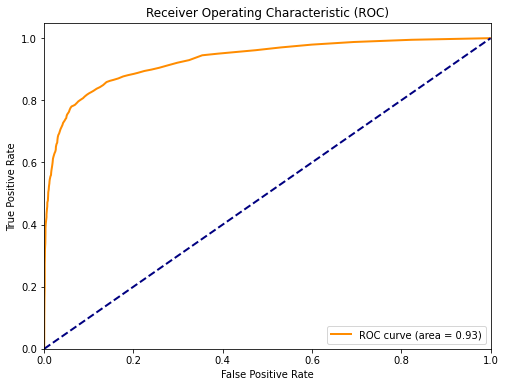

In [37]:
# Define classifier
clf1 = RandomForestClassifier(random_state=42)

# Evaluate classifier by calling evaluate_classifier function
accuracy1, auc1, training_time1 = evaluate_classifier(clf1, X_train, y_train, X_test, y_test)


Feature Importance:
energy: 0.06918868723068303
cTheta: 0.054206956415015974
phi: 0.04797820514347336
prob_b: 0.3352146329488582
spheri: 0.07002293644833432
pt2rel: 0.05951322890997682
multip: 0.06153649207614388
bqvjet: 0.24989461491367976
ptlrel: 0.05244424591383464


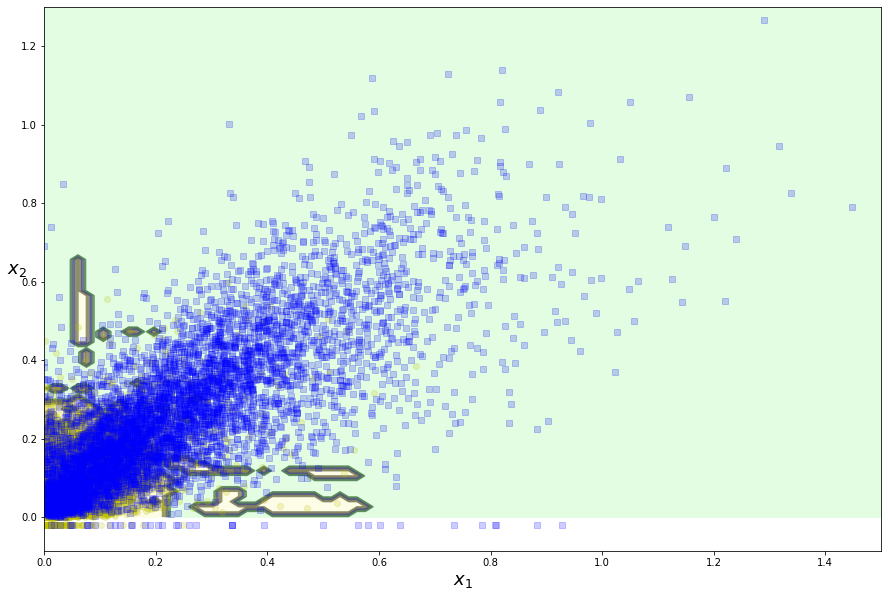

In [38]:
# Find feature importance and plot decision surface over top 2 features
plot_decision_boundary(clf1, X_train, y_train, input_variables, alpha = 0.2)

## 2. Finetuned Random Forest

Best hyperparameters:
max_leaf_nodes: None
n_estimators: 800
Training time: 52.65 seconds

AUC Value: 0.9321466157790147

Accuracy Score: 0.9060936120105976

Confusion Matrix:
[[5050  201]
 [ 437 1106]]


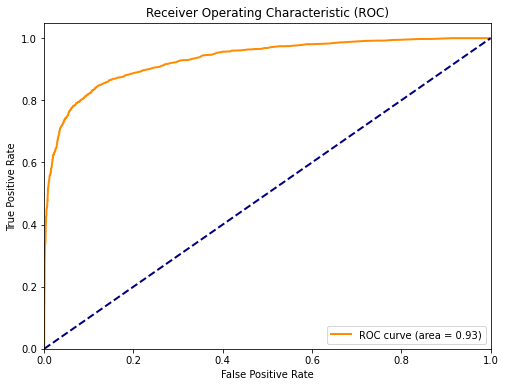

In [39]:
# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [200, 500, 800],
    'max_leaf_nodes': [None, 16, 32]
}

clf2 = RandomForestClassifier(random_state=42)  # define classifier

# Fine-tune and optimize Model by calling cross_validate function
accuracy2, auc2, training_time2, clf2 = cross_validate_classifier(clf2, param_grid_rf, X_train, y_train, X_test, y_test)


Feature Importance:
energy: 0.06949129682177253
cTheta: 0.05413461683702247
phi: 0.048250797976457385
prob_b: 0.33873062765367273
spheri: 0.07012815863781442
pt2rel: 0.059456593877213526
multip: 0.06252289863021461
bqvjet: 0.24260397794092367
ptlrel: 0.05468103162490877


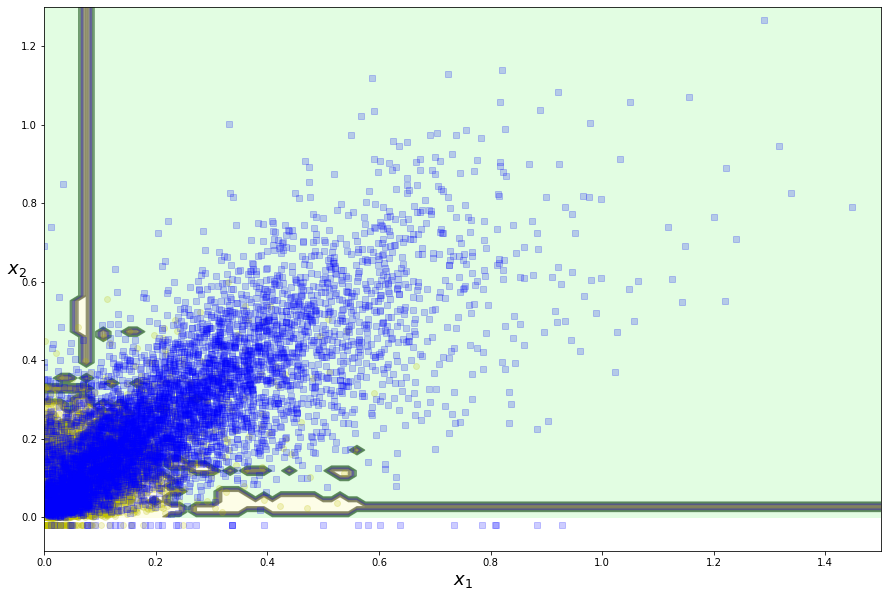

In [40]:
# Find feature importance and plot decision surface over top 2 features
plot_decision_boundary(clf2, X_train, y_train, input_variables, alpha = 0.2)

## 3. Bagging Random Forest

Training time: 0.92 seconds

AUC Value: 0.9228370289743905

Accuracy Score: 0.8987341772151899

Confusion Matrix:
[[5059  192]
 [ 496 1047]]


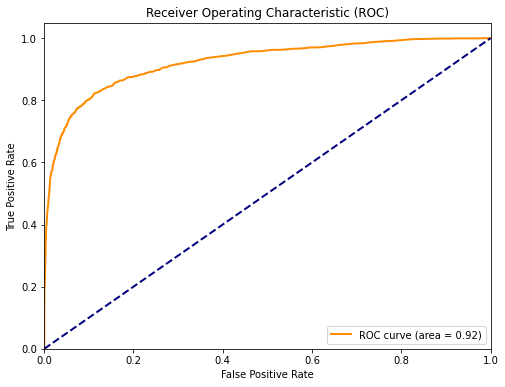

In [63]:
# Define classifier
clf3 = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)

# Evaluate classifier by calling evaluate_classifier function
accuracy3, auc3, training_time3 = evaluate_classifier(clf3, X_train, y_train, X_test, y_test)

## 4. Finetuned Bagging Random Forest

Best hyperparameters:
base_estimator__max_depth: None
base_estimator__max_leaf_nodes: 32
max_samples: 200
n_estimators: 500
Training time: 1.08 seconds

AUC Value: 0.9252206751841734

Accuracy Score: 0.9032970267883427

Confusion Matrix:
[[5069  182]
 [ 475 1068]]


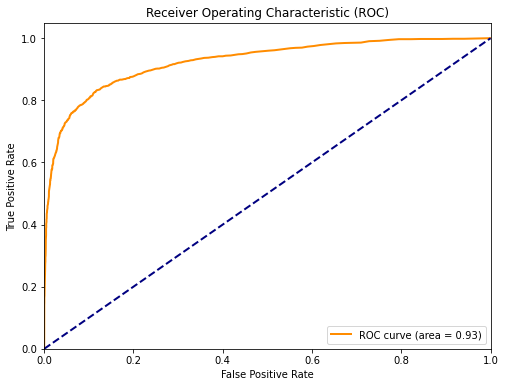

In [42]:
# Define classifier
clf4 = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    random_state=42
)

# Define hyperparameter grid
param_grid_bag = {
    'n_estimators': [100, 200, 500],
    'max_samples': [50, 100, 200],
    'base_estimator__max_depth': [None, 3, 6],
    'base_estimator__max_leaf_nodes': [None, 16, 32]
}

# Fine-tune and optimize model
accuracy4, auc4, training_time4, clf4 = cross_validate_classifier(clf4, param_grid_bag, X_train, y_train, X_test, y_test)

## 5. XGBoost

Training time: 0.85 seconds

AUC Value: 0.9298146833248315

Accuracy Score: 0.9012363850456285

Confusion Matrix:
[[5036  215]
 [ 456 1087]]


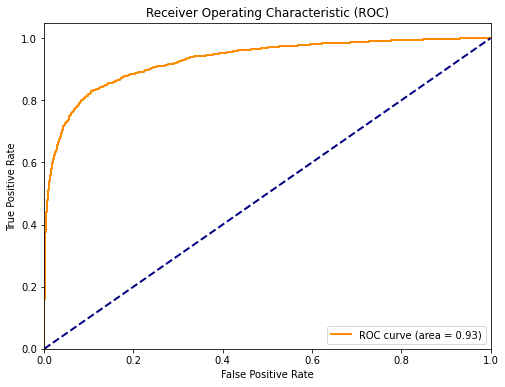

In [43]:
# Define classifier
clf5 = XGBClassifier(random_state=42)

# Evaluate classifier by calling evaluate_classifier function
accuracy5, auc5, training_time5 = evaluate_classifier(clf5, X_train, y_train, X_test, y_test)


Feature Importance:
energy: 0.055335402488708496
cTheta: 0.03351692855358124
phi: 0.029113220050930977
prob_b: 0.5444449186325073
spheri: 0.05141309276223183
pt2rel: 0.04132714495062828
multip: 0.045433275401592255
bqvjet: 0.10256248712539673
ptlrel: 0.09685346484184265


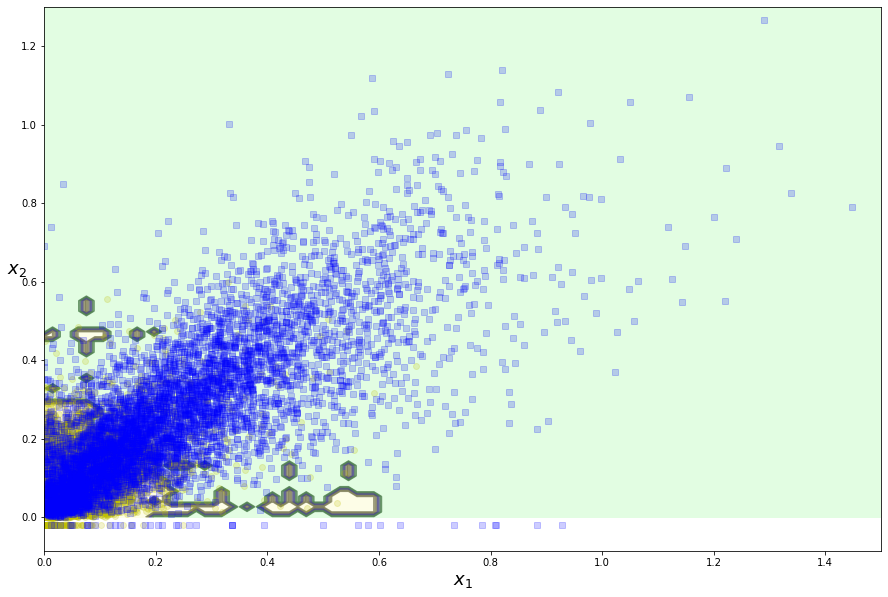

In [44]:
# Find feature importance and plot decision surface over top 2 features
plot_decision_boundary(clf5, X_train, y_train, input_variables, alpha = 0.2)

## 6. Finetuned XGBoost

Best hyperparameters:
colsample_bytree: 0.8
learning_rate: 0.01
max_depth: 6
n_estimators: 500
subsample: 0.8
Training time: 3.97 seconds

AUC Value: 0.9374496824540905

Accuracy Score: 0.9055048572269649

Confusion Matrix:
[[5065  186]
 [ 456 1087]]


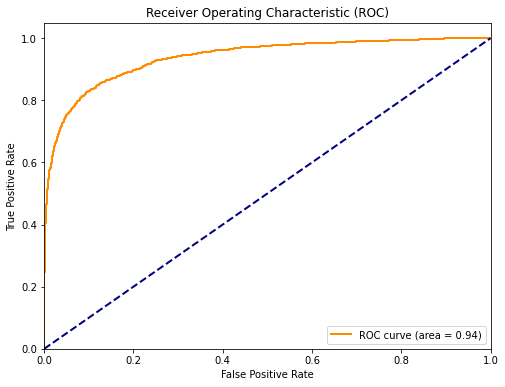

In [45]:
# Define classifier
clf6 = XGBClassifier(random_state=42)

# Define hyperparameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Fine-tune and optimize Model
accuracy6, auc6, training_time6, clf6 = cross_validate_classifier(clf6, param_grid_xgb, X_train, y_train, X_test, y_test)


Feature Importance:
energy: 0.044205594807863235
cTheta: 0.026863424107432365
phi: 0.018253102898597717
prob_b: 0.5207167863845825
spheri: 0.04819812253117561
pt2rel: 0.0348154753446579
multip: 0.040317971259355545
bqvjet: 0.18250949680805206
ptlrel: 0.084120012819767


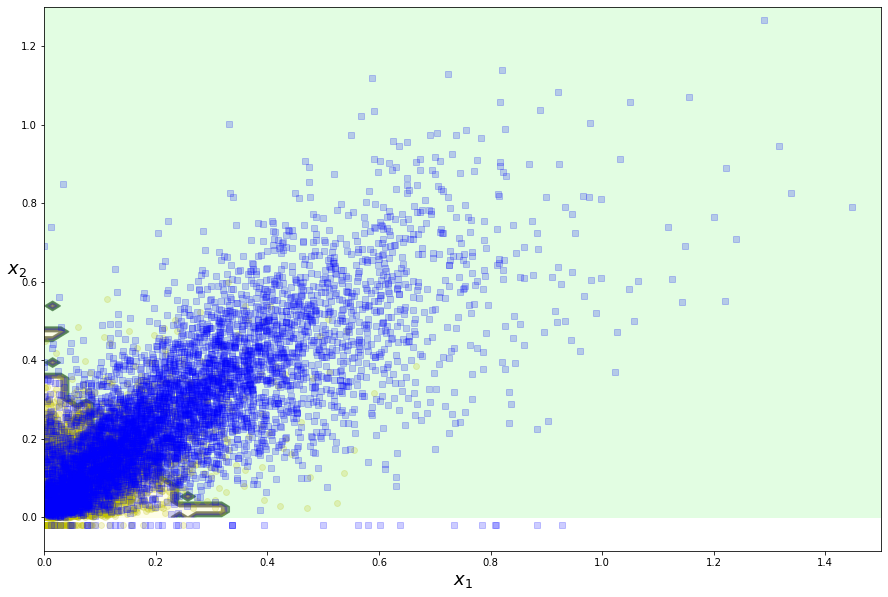

In [46]:
# Find feature importance and plot decision surface over top 2 features
plot_decision_boundary(clf6, X_train, y_train, input_variables, alpha = 0.2)

## 7. Light GBM

[LightGBM] [Info] Number of positive: 6117, number of negative: 21057
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 27174, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225105 -> initscore=-1.236161
[LightGBM] [Info] Start training from score -1.236161
Training time: 0.20 seconds

AUC Value: 0.9357397961293179

Accuracy Score: 0.9055048572269649

Confusion Matrix:
[[5047  204]
 [ 438 1105]]


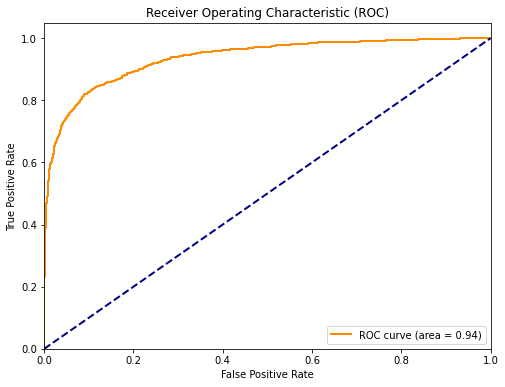

In [47]:
# Define classifier
clf7 = lgb.LGBMClassifier(random_state=42)

# Evaluate classifier by calling evaluate_classifier function
accuracy7, auc7, training_time7 = evaluate_classifier(clf7, X_train, y_train, X_test, y_test)

[LightGBM] [Info] Number of positive: 6117, number of negative: 21057
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 27174, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225105 -> initscore=-1.236161
[LightGBM] [Info] Start training from score -1.236161

Feature Importance:
energy: 413
cTheta: 317
phi: 263
prob_b: 361
spheri: 368
pt2rel: 386
multip: 324
bqvjet: 362
ptlrel: 206
[LightGBM] [Info] Number of positive: 6117, number of negative: 21057
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 27174, number of used features: 2
[LightGBM] [Info] [

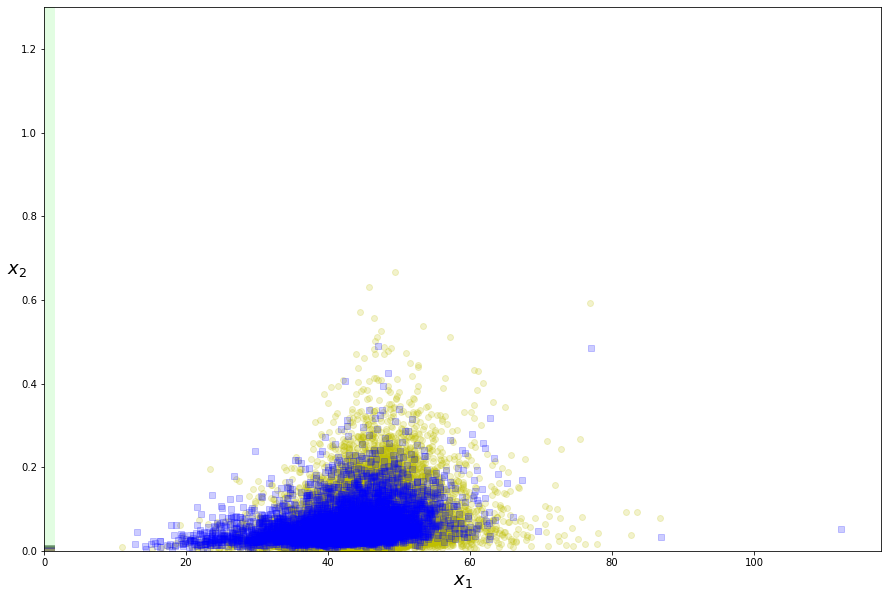

In [75]:
# Find feature importance and plot decision surface over top 2 features
plot_decision_boundary(clf7, X_train, y_train, input_variables, alpha = 0.2)

## 8. Finetuned LGMB

[LightGBM] [Info] Number of positive: 4078, number of negative: 14038
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 18116, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225105 -> initscore=-1.236161
[LightGBM] [Info] Start training from score -1.236161
[LightGBM] [Info] Number of positive: 4078, number of negative: 14038
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 18116, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225105 -> initscore=-1.236161
[LightGBM] [Info] Start training from score -1.236161
[LightGBM] [Info] Number of positive: 4078, number of negative: 14038
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 18116, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225105 -> initscore=-1.236161
[LightGBM] [Info] Start training from score -1.236161
[LightGBM]

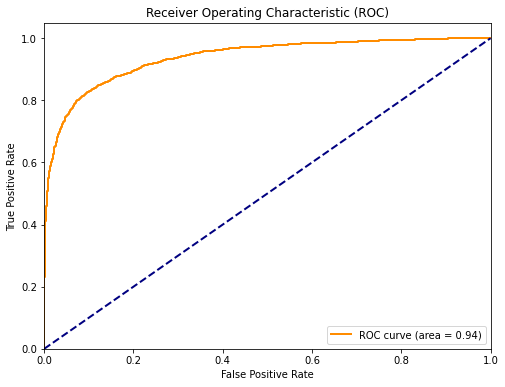

In [49]:
# Turn off LightGBM logging
os.environ['LIGHTGBM_LOGGER'] = 'OFF'
# Filter out warning messages
warnings.filterwarnings('ignore')

# Define classifier
clf8 = lgb.LGBMClassifier(random_state=42, force_col_wise=True)

# Define hyperparameter grid
param_grid_lgbm  = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [10, 30, 50],
    }

# Fine-tune and optimize Model
accuracy8, auc8, training_time8, clf8 = cross_validate_classifier(clf8, param_grid_lgbm, X_train, y_train, X_test, y_test)

[LightGBM] [Info] Number of positive: 6117, number of negative: 21057
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 27174, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225105 -> initscore=-1.236161
[LightGBM] [Info] Start training from score -1.236161

Feature Importance:
energy: 243
cTheta: 146
phi: 49
prob_b: 279
spheri: 211
pt2rel: 240
multip: 185
bqvjet: 254
ptlrel: 193
[LightGBM] [Info] Number of positive: 6117, number of negative: 21057
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 27174, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225105 -> initscore=-1.236161
[LightGBM] [Info] Start training from score -1.236161


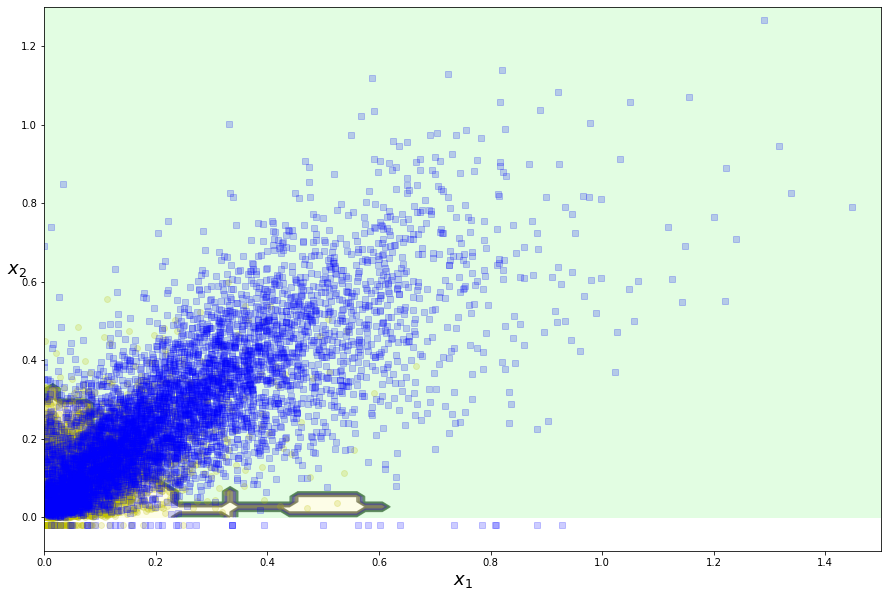

In [50]:
# Find feature importance and plot decision surface over top 2 features
plot_decision_boundary(clf8, X_train, y_train, input_variables, alpha = 0.2)

# Regression task

Build a tree regressor to predict the energy column of each collision.

Train 3 ensemble methods: 1. Random Forest, 2. XGBoost and 3. LightGBM

For each:
* Report Accuracy for each model (Test accuracy & prediciton vs real curve)
* Report training times
* Find the most important features & plot decision surface between top two features
* Bonus: Improve performance using k-fold cross-validation

## Create General Function

In [51]:
def evaluate_regression(regression_model, X_train, y_train, X_test, y_test):
    # Fit the model to predict the target variable
    start_time = time.time() # start timer
    
    regression_model.fit(X_train, y_train)
    
    end_time = time.time() # end timer
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds") # print time needed to fit the data
    
    # Get the model's predictions for the validation set
    y_pred = regression_model.predict(X_test)

    # Calculate the mean squared error (MSE) to evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    # Visualize the model predictions vs. the real values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel("Real Values")
    plt.ylabel("Predictions")
    plt.title("Model Predictions vs. Real Values")
    plt.show()
    
    return mse, training_time

In [55]:
def cross_validate_regression(regression_model, param_grid, X_train, y_train, X_test, y_test, cv=3, scoring='neg_mean_squared_error'):

    # Initialize GridSearchCV with the model and parameter grid
    grid_search = GridSearchCV(regression_model, param_grid, cv=cv, scoring=scoring)

    # Fit the model to the data to find the best hyperparameters
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best hyperparameters:")
    for param_name, param_value in best_params.items():
        print(f"{param_name}: {param_value}")

    # Get the best trained regression model
    best_regression_model = grid_search.best_estimator_

    # Evaluate the best model on the test set and plot the predictions vs. real values
    mse, training_time = evaluate_regression(best_regression_model, X_train, y_train, X_test, y_test)

    return mse, training_time, best_regression_model

## 1. Random Forest

Training time: 17.66 seconds
Mean Squared Error: 24.555407809766606


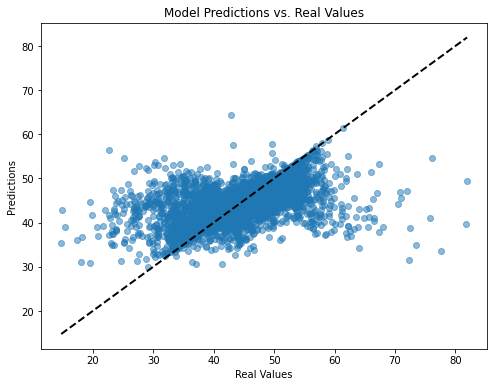

In [53]:
# Define the model
regression_model1 = RandomForestRegressor(n_estimators=100, random_state=42)

# Evaluate the model using function
mse1, training_time_reg1 = evaluate_regression(regression_model1, X_train2, y_train2, X_test2, y_test2)

## 2. Finetuned Random Forest

Best hyperparameters:
max_depth: None
min_samples_leaf: 4
min_samples_split: 10
n_estimators: 200
Training time: 29.14 seconds
Mean Squared Error: 23.738697891129448


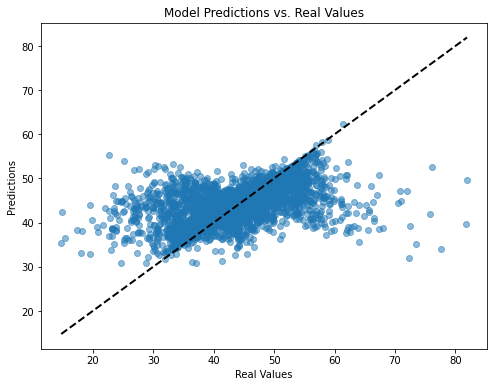

In [56]:
# Define the hyperparameter grid for each model
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define a model
regression_model2 = RandomForestRegressor(random_state=42)

# Perform cross-validation for model
mse2, training_time_reg2, regression_model2 = cross_validate_regression(regression_model2, param_grid_rf, X_train2, y_train2, X_test2, y_test2)

## 3. XGBoost

Training time: 0.79 seconds
Mean Squared Error: 23.61570204648099


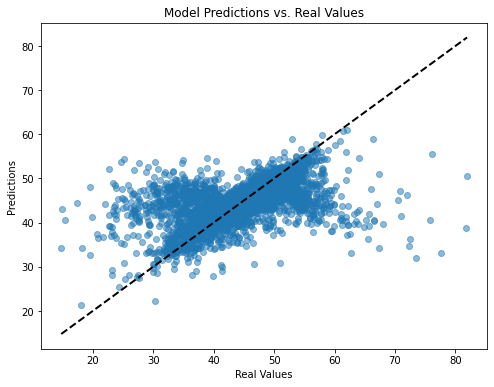

In [64]:
# Define the XGBoost regressor
regression_model3 = XGBRegressor(random_state=42)

# Evaluate the model using function
mse3, training_time_reg3 = evaluate_regression(regression_model3, X_train2, y_train2, X_test2, y_test2)

## 4. Finetuned XGBoost

Best hyperparameters:
learning_rate: 0.1
max_depth: 8
n_estimators: 100
Training time: 1.06 seconds
Mean Squared Error: 22.6487146512392


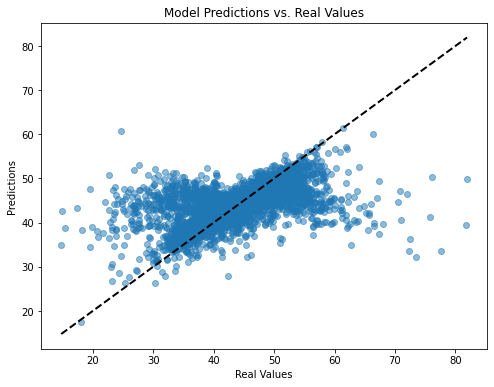

In [65]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Define a model
regression_model4 = XGBRegressor(random_state=42)

# Perform cross-validation for model
mse4, training_time_reg4, regression_model4 = cross_validate_regression(regression_model4, param_grid_xgb, X_train2, y_train2, X_test2, y_test2)

## 5. Light GBM

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 27174, number of used features: 8
[LightGBM] [Info] Start training from score 44.845491
Training time: 0.19 seconds
Mean Squared Error: 23.59469001048066


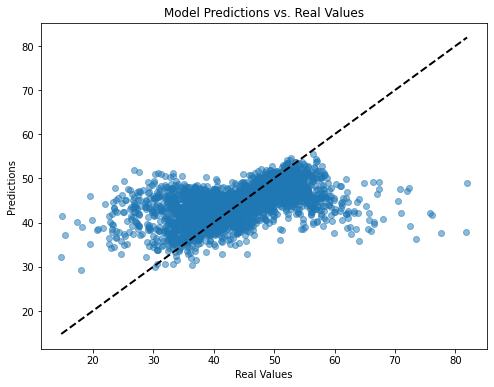

In [66]:
# Define the LGBMRegressor
regression_model5 = lgb.LGBMRegressor(random_state=42)

# Evaluate the model using function
mse5, training_time_reg5 = evaluate_regression(regression_model5, X_train2, y_train2, X_test2, y_test2)

# Comparison Simple Models versus Ensemble models

Compare results of Notebook from Session 7 (decision trees) to the results of the ensemble methods.

In [76]:
# Comparison of all Classifier Models
print("\n\033[1mComparison of Classifier Models\033[0m")

print("\n\033[1mEnsemble Methods:\033[0m")
print("\n\033[1m1. Accuracy:\033[0m")
print("Baseline Random Forest:", accuracy1)
print("Finetuned Random Forest:", accuracy2)
print("Bagging Random Forest:", accuracy3)
print("Finetuned Bagging Random Forest:", accuracy4)
print("XG Boost:", accuracy5)
print("Finetuned XG Boost:", accuracy6)
print("Light GBM:", accuracy7)
print("Finetuned Light GBM:", accuracy8)

print("\n\033[1m2. AUC:\033[0m")
print("Baseline Random Forest:", auc1)
print("Finetuned Random Forest:", auc2)
print("Bagging Random Forest:", auc3)
print("Finetuned Bagging Random Forest:", auc4)
print("XG Boost:", auc5)
print("Finetuned XG Boost:", auc6)
print("Light GBM:", auc7)
print("Finetuned Light GBM:", auc8)

print("\n\033[1m3. Training Time:\033[0m")
print("Baseline Random Forest:", training_time1)
print("Finetuned Random Forest:", training_time2)
print("Bagging Random Forest:",training_time3)
print("Finetuned Bagging Random Forest:", training_time4)
print("XG Boost:", training_time5)
print("Finetuned XG Boost:", training_time6)
print("Light GBM:", training_time7)
print("Finetuned Light GBM:", training_time8)

print("\n\033[1mNotebook from Session 7 (Decision Trees):\033[0m")
print("\n\033[1m1. Accuracy:\033[0m")
print("Baseline Decision Tree:","0.8467765675596114")
print("Finetuned Decision Tree:", "0.8928466293788637")

print("\n\033[1m2. AUC:\033[0m")
print("Baseline Decision Tree:","0.780738420253543")
print("Finetuned Decision Tree:", "0.899565907008028")


Comparison of Classifier Models

Ensemble Methods:

1. Accuracy:
Baseline Random Forest: 0.9050632911392406
Finetuned Random Forest: 0.9060936120105976
Bagging Random Forest: 0.8987341772151899
Finetuned Bagging Random Forest: 0.9032970267883427
XG Boost: 0.9012363850456285
Finetuned XG Boost: 0.9055048572269649
Light GBM: 0.9055048572269649
Finetuned Light GBM: 0.9059464233146894

2. AUC:
Baseline Random Forest: 0.9300487528653926
Finetuned Random Forest: 0.9321466157790147
Bagging Random Forest: 0.9228370289743905
Finetuned Bagging Random Forest: 0.9252206751841734
XG Boost: 0.9298146833248315
Finetuned XG Boost: 0.9374496824540905
Light GBM: 0.9357397961293179
Finetuned Light GBM: 0.9371497673559819

3. Training Time:
Baseline Random Forest: 5.978298187255859
Finetuned Random Forest: 52.64811110496521
Bagging Random Forest: 0.9151921272277832
Finetuned Bagging Random Forest: 1.075350046157837
XG Boost: 0.8531970977783203
Finetuned XG Boost: 3.973184823989868
Light GBM: 0.1969788074

**FINDINGS**

**Accuracy Comparison:**
* The accuracy of the classifiers is generally high, ranging from approximately 0.8987 to 0.9061. The differences in accuracy among the models are relatively smaller compared to the AUC values.
* The finetuned versions of the classifiers generally show slightly better accuracy than their baseline counterparts.
* The Finetuned Random Forest model achieved the highest accuracy.
* Finetuned XG Boost, Light GBM, Finetuned Light GBM and Baseline Random Forest models achieved similar accuracies around 0.905.
* The Baseline Bagging Random Forest, and XG Boost models had slightly lower accuracies.

**AUC Comparison:**
* The Finetuned XG Boost and Finetuned Light GBM models achieved the highest AUC values.
* Finetuned Random Forest and Light GBM also performed well with AUC values.
* The Baseline Random Forest and Bagging Random Forest models had relatively lower AUC values

**Training Time Comparison:**
* The Light GBM models (baseline and finetuned) demonstrated the lowest training time, making it the fastest model to train.
* The Finetuned Random Forest model required the longest training time with over 52, significantly higher than other models.
* The other models had moderate training times

**Conclusion:**
* Finetuned XG Boost and Finetuned Light GBM models are concluded as the best models as they achieved the highest AUC values with reasonably high accuracy and relatively short training times.

**Comparison to Decision Tree Models (Session 7)**
* In the notebook from Session 7, the Decision Tree classifiers had lower accuracy as well as lower AUC values.
* While the baseline Decision Tree was clearly outperformed by the ensemble methods, the finetuned decision tree does not perform very badly. With valued of slightly over 0.9 this decision tree model can competewith some ensemble methods such as the Bagging Random Forest.
* However, overall ensemble methods outperform decision trees which makes sense because they combine the predictions of multiple individual models. Therebey, they result in more accurate and robust predictions. Decision trees are simple and prone to overfitting, but ensemble methods reduce this risk by averaging or combining the predictions of multiple trees. This diversity in the models helps capture different patterns in the data, leading to better generalization and improved performance in various tasks, such as classification and regression. Consequently, ensemble methods are preferred in practice for achieving higher accuracy and better predictive power compared to standalone decision trees.

In [77]:
# Comparison of all Classifier Models
print("\n\033[1mComparison of Regression Models\033[0m")

print("\n\033[1mEnsemble Methods:\033[0m")
print("\n\033[1m1. Mean Squared Error:\033[0m")
print("Baseline Random Forest:", mse1)
print("Finetuned Random Forest:", mse2)
print("XG Boost:", mse3)
print("Finetuned XG Boost:", mse4)
print("Light GBM:", mse5)

print("\n\033[1m2. Training Times:\033[0m")
print("Baseline Random Forest:", training_time_reg1)
print("Finetuned Random Forest:", training_time_reg2)
print("XG Boost:", training_time_reg3)
print("Finetuned XG Boost:", training_time_reg4)
print("Light GBM:", training_time_reg5)

print("\n\033[1mNotebook from Session 7 (Decision Trees):\033[0m")
print("\n\033[1m1. Mean Squared Error:\033[0m")
print("Baseline Decision Tree:","47.98211938609902")
print("Finetuned Decision Tree:", "28.97041049575996")


Comparison of Regression Models

Ensemble Methods:

1. Mean Squared Error:
Baseline Random Forest: 24.555407809766606
Finetuned Random Forest: 23.738697891129448
XG Boost: 23.61570204648099
Finetuned XG Boost: 22.6487146512392
Light GBM: 23.59469001048066

2. Training Times:
Baseline Random Forest: 0.8145716190338135
Finetuned Random Forest: 29.136436223983765
XG Boost: 0.7937490940093994
Finetuned XG Boost: 1.0626940727233887
Light GBM: 0.1893141269683838

Notebook from Session 7 (Decision Trees):

1. Mean Squared Error:
Baseline Decision Tree: 47.98211938609902
Finetuned Decision Tree: 28.97041049575996


**FINDINGS**

**Mean Squared Error Comparison:**
* The Mean Squared Error (MSE) values for the regression models range from approximately 22.6 to 24.6.
* Finetuned XG Boost achieved the lowest MSE of 22.6, indicating better performance.
* Baseline Random Forest, Finetuned Random Forest, XG Boost, and Light GBM models performed similarly, with MSE values around 23.6 to 23.7.

**Training Time Comparison:**
* The Light GBM model demostrates the shortest training time.
* Finetuned Random Forest required the longest training time, significantly higher than the other models, at approximately 29.1 seconds.
* Baseline Random Forest and XG Boost models had moderate training times.

**Conclusion:**
* Finetuned XG Boost stands out as the best regression model, achieving the lowest Mean Squared Error with a reasonable training time.
* Light GBM also performs well, with relatively low MSE and the shortest training time among the models.
* The finetuned decision tree from Session 7 had an MSE of 28.97, indicating that the ensemble methods outperform it, as they achieve lower MSE values.

**Comparison to Decision Tree Models (Session 7)**
* In the notebook from Session 7, the Decision Tree classifiers had lower MSE compared to all ensemble models.
* The baseline decision tree had much higher MSE with almost 48 compared to the range of 22 to 24 of all ensemble models. Though the finetuned decision tree comes closer to the MSE of the other models with approx. 29, it is still much higher and thus worse in performing the regression task.
* Similar to the classificaiton task, overall ensemble methods outperform decision trees. The explanation is the same as described earlier.